## Introduction

### In this notebook we use [PointNet](https://arxiv.org/abs/1612.00593) to perform 3D Object Classification on [ModelNet10 Dataset](http://modelnet.cs.princeton.edu/#).

<h3><center>Applications of PointNet</center></h3>
<img src="http://stanford.edu/~rqi/pointnet/images/teaser.jpg" width="600" height="500"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/pdf/1612.00593.pdf">Source: PointNet [Charles R. Qi et. al.]</a></center></h4>

## Acknowledgements

### This work was inspired by and borrows code from [Nikita Karaev's](https://github.com/nikitakaraevv) [PointNet implementation](https://github.com/nikitakaraevv/pointnet).

### Libraries 📚⬇

In [1]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pathlib import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
!kaggle datasets download -d balraj98/modelnet10-princeton-3d-object-dataset

 25%|█████████▊                              | 112M/454M [00:10<00:30, 11.6MB/s]^C
 25%|█████████▉                              | 113M/454M [00:10<00:32, 11.0MB/s]
User cancelled operation


In [ ]:
import zipfile

with zipfile.ZipFile("modelnet10-princeton-3d-object-dataset.zip", mode="r") as data:
     data.extractall()

In [ ]:
os.remove("modelnet10-princeton-3d-object-dataset.zip")

In [6]:
os.chdir("/home/dmitry/Рабочий стол/ClassificationPointNet3D")

In [2]:
path = Path("/home/dmitry/Рабочий стол/ClassificationPointNet3D/app/data/ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### Utility Functions

In [3]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [4]:
with open(path/"sofa/train/sofa_0002.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)

6433

In [ ]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='yellowgreen', opacity=0.50, i=i,j=j,k=k)]).show()

In [ ]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z, mode='markers')]).show()

In [ ]:
pcshow(x,y,z)

In [8]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [ ]:
pointcloud = PointSampler(3000)((verts, faces))
pcshow(*pointcloud.T)

In [10]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

In [12]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [ ]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
pcshow(*noisy_rot_pointcloud.T)

In [14]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [15]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

### Define Datasets / Dataloaders

In [9]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [10]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [11]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [12]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [13]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [15]:
train_loader = DataLoader(dataset=train_ds, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=8)

<h3><center>PointNet Model Architecture</center></h3>
<img src="http://stanford.edu/~rqi/pointnet/images/pointnet.jpg" width="750" height="750"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/pdf/1612.00593.pdf">Source: PointNet [Charles R. Qi et. al.]</a></center></h4>

### Model Definition

In [16]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [17]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
pointnet = PointNet()
pointnet.to(device);

# Load a pre-trained model if it exists
#pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

In [20]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)

### Train PointNet

In [21]:
def train(model, train_loader, val_loader=None,  epochs=1):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 5 == 4:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        torch.save(pointnet.state_dict(), "save.pth")

In [23]:
torch.cuda.empty_cache()

In [24]:
train(pointnet, train_loader, valid_loader)

[Epoch: 1, Batch:    5 /  499], loss: 1.187
[Epoch: 1, Batch:   10 /  499], loss: 1.139
[Epoch: 1, Batch:   15 /  499], loss: 1.099
[Epoch: 1, Batch:   20 /  499], loss: 1.037
[Epoch: 1, Batch:   25 /  499], loss: 0.990
[Epoch: 1, Batch:   30 /  499], loss: 0.966
[Epoch: 1, Batch:   35 /  499], loss: 1.020
[Epoch: 1, Batch:   40 /  499], loss: 1.047
[Epoch: 1, Batch:   45 /  499], loss: 1.028
[Epoch: 1, Batch:   50 /  499], loss: 0.960
[Epoch: 1, Batch:   55 /  499], loss: 0.958
[Epoch: 1, Batch:   60 /  499], loss: 0.905
[Epoch: 1, Batch:   65 /  499], loss: 0.869
[Epoch: 1, Batch:   70 /  499], loss: 0.837
[Epoch: 1, Batch:   75 /  499], loss: 0.889
[Epoch: 1, Batch:   80 /  499], loss: 0.896
[Epoch: 1, Batch:   85 /  499], loss: 0.877
[Epoch: 1, Batch:   90 /  499], loss: 0.840
[Epoch: 1, Batch:   95 /  499], loss: 0.873
[Epoch: 1, Batch:  100 /  499], loss: 0.792
[Epoch: 1, Batch:  105 /  499], loss: 0.927
[Epoch: 1, Batch:  110 /  499], loss: 0.826
[Epoch: 1, Batch:  115 /  499], 

KeyboardInterrupt: 

### Test PointNet

In [48]:
data['pointcloud'][0]

tensor([[-0.4894,  0.5074, -0.0846],
        [-0.2702, -0.7409,  0.1089],
        [ 0.4911,  0.6456,  0.1348],
        ...,
        [ 0.0498,  0.2054, -0.0846],
        [-0.5670, -0.1031,  0.0134],
        [ 0.3883, -0.6815,  0.0056]], dtype=torch.float64)

In [32]:
pointnet.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
        
        inputs, labels = data['pointcloud'].float(), data['category']
        pointnet.to('cpu')
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /  114]
Batch [   2 /  114]
Batch [   3 /  114]
Batch [   4 /  114]
Batch [   5 /  114]
Batch [   6 /  114]
Batch [   7 /  114]
Batch [   8 /  114]
Batch [   9 /  114]
Batch [  10 /  114]
Batch [  11 /  114]
Batch [  12 /  114]


KeyboardInterrupt: 

In [41]:
cm = confusion_matrix(all_labels, all_preds)

In [42]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/tmp/ipykernel_292642/2299670295.py:4: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


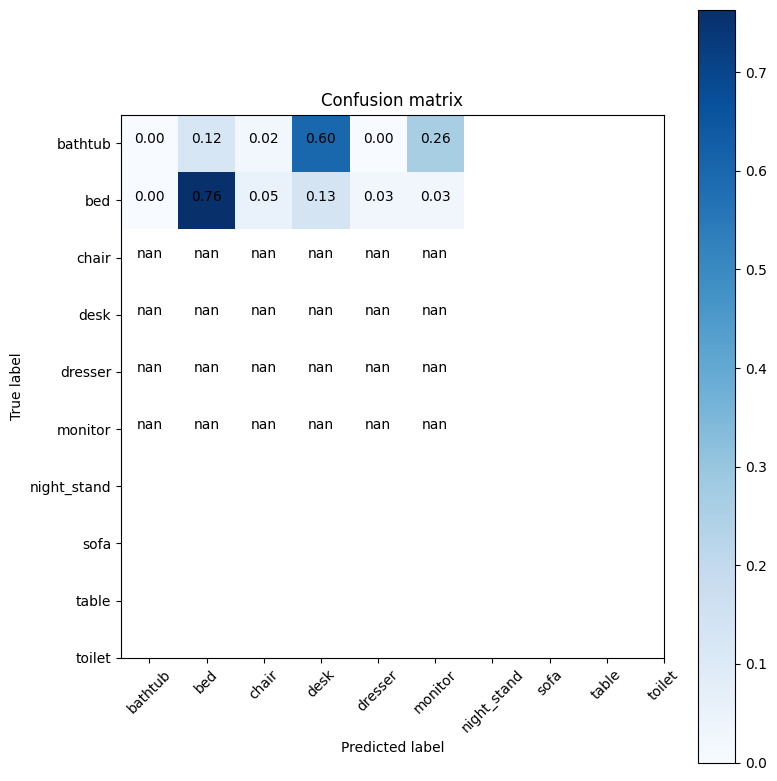

In [43]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


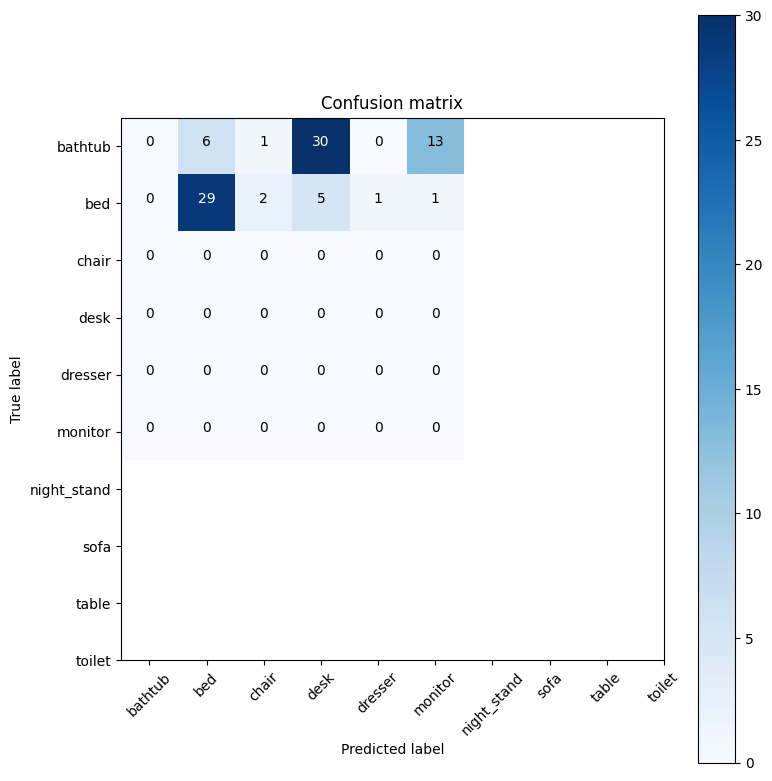

In [44]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)